# Multivariate Regular Variation

Notebook to play around with different multivariate regular variation concepts and estimation techniques.

In [11]:
library(mvtnorm)
library(dplyr)
library(ggplot2)

source('~/isolines_uq/scripts/R/auxiliary_scripts/distributionIsolines.R')

### Heffernan and Tawn (2007)


In [12]:
n <- 10000
dat <- data.frame(rmvnorm(n=n, mean=rep(0,2), sigma=matrix(c(1, 0.4, 0.4, 1), nrow=2)))

In [13]:
frec_dat = data.frame(Z1 = -1/log(pnorm(dat$X1, mean=0, sd=1)), Z2 = -1/log(pnorm(dat$X2, mean=0, sd=1)))

In [14]:
hillEstimate <- function(sorted, k) {   
    sorted_truncated <- sorted[1:k]
    return((1/k)*sum(log(sorted_truncated/sorted[k+1])))
}

In [57]:
survfuncEstimate <- function(x, y, k, dat) {
    
    n <- nrow(dat)
    xdat <- dat[,1]
    ydat <- dat[,2]
    x_sorted <- sort(xdat, decreasing=TRUE)
    y_sorted <- sort(ydat, decreasing=TRUE)
    x_antiranks <- order(dat[,1], decreasing=TRUE)
    y_antiranks <- order(dat[,2], decreasing=TRUE) 
    
    alphax <- hillEstimate(x_sorted, k)
    alphay <- hillEstimate(y_sorted, k)
    #alphax <- 1
    #alphay <- 1
    
    m <- pmax(1/x_antiranks, 1/y_antiranks)
    sorted_m <- sort(m, decreasing = TRUE)
    
    bx <- x_sorted[ceiling(1/sorted_m[k])]
    by <- y_sorted[ceiling(1/sorted_m[k])]
    
    prob <- mean(((1/x_antiranks)/sorted_m[k] > (x/bx)^(alphax)) & 
         ((1/y_antiranks)/sorted_m[k] > (y/by)^(alphay)))
    
    return(prob)
}

In [69]:
# making the Starica plot

staricaRatio <- function(dat, k, u, x_antiranks, y_antiranks) {
    
    pts_x <- k/x_antiranks
    pts_y <- k/y_antiranks
    
    est_measure_u <- (1/k)*sum(sqrt(pts_x**2 + pts_y**2) > u)
    est_measure <- (1/k)*sum(sqrt(pts_x**2 + pts_y**2) > 1)
    
    ratio <- (est_measure_u*u)/(est_measure)
    
    return(ratio)   
}

In [70]:
computeKScore <- function(k, us, dat) {
    
    n <- nrow(dat)
    xdat <- dat[,1]
    ydat <- dat[,2]
    x_sorted <- sort(xdat, decreasing=TRUE)
    y_sorted <- sort(ydat, decreasing=TRUE)
    x_antiranks <- order(dat[,1], decreasing=TRUE)
    y_antiranks <- order(dat[,2], decreasing=TRUE)
    
    staricaRatios_k <- rep(NA, length(us))

    for (i in 1:length(us)) {
        staricaRatios_k[i] <- staricaRatio(dat, k, us[i], x_antiranks, y_antiranks)
    }
    
    res_list <- list()
    
    score <- sum((staricaRatios_k - 1)**2)
    res_list$score = score
    res_list$ratios = staricaRatios_k
    
    return(res_list)
    
}

In [60]:
us <- seq(0, 10, length.out=100)
ks <- seq(1,100)*100

res <- computeKScore(ks[4], us, frec_dat)

In [62]:
us <- seq(1, 10, length.out=100)
ks <- seq(1,100)*100
k_scores <- rep(NA, length(ks))

for (i in 1:length(ks)) {

    k_scores[i] <- computeKScore(ks[i], us, frec_dat)$score
    
}

In [65]:
xs <- seq(30, 90, length.out = 20)
ys <- seq(30, 90, length.out = 20)

probs_HT <- rep(NA, length(xs))
probs_true <- rep(NA, length(xs))
probs_emp <- rep(NA, length(xs))


for (i in 1:length(xs)) {
    
    probs_HT[i] <- survfuncEstimate(xs[i],ys[i],ks[which.min(k_scores)], frec_dat)
    probs_emp[i] <- mean((frec_dat[,1] > xs[i]) & (frec_dat[,2] > ys[i]))
    
    m <- 1000000
    test_dat <- data.frame(rmvnorm(n=m, mean=rep(0,2), sigma=matrix(c(1, 0.4, 0.4, 1), nrow=2)))
    frec_test = data.frame(Z1 = -1/log(pnorm(test_dat$X1, mean=0, sd=1)), Z2 = -1/log(pnorm(test_dat$X2, mean=0, sd=1)))
    probs_true[i] <- mean((frec_test[,1] > xs[i]) & (frec_test[,2] > ys[i]))

}

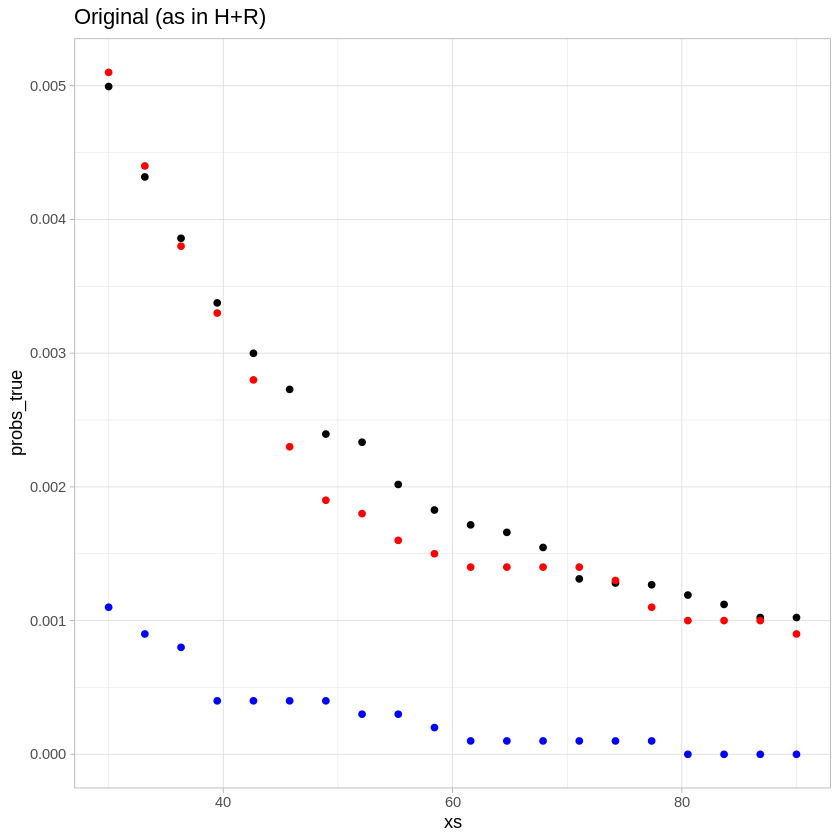

In [67]:
plt_df <- data.frame(xs=xs, probs_HT=probs_HT, probs_emp=probs_emp, probs_true=probs_true)
ggplot(plt_df) + geom_point(aes(x = xs, y=probs_true)) + geom_point(aes(x=xs, y=probs_emp), color='red') + geom_point(aes(x = xs, y=probs_HT), color='blue') + ggtitle('Original (as in H+R)') + theme_light()

In [68]:
survfuncEstimate <- function(x, y, k, dat) {
    
    n <- nrow(dat)
    xdat <- dat[,1]
    ydat <- dat[,2]
    x_sorted <- sort(xdat, decreasing=TRUE)
    y_sorted <- sort(ydat, decreasing=TRUE)
    x_antiranks <- order(dat[,1], decreasing=TRUE)
    y_antiranks <- order(dat[,2], decreasing=TRUE) 
    
    #alphax <- hillEstimate(x_sorted, k)
    #alphay <- hillEstimate(y_sorted, k)
    alphax <- 1
    alphay <- 1
    
    m <- pmax(1/x_antiranks, 1/y_antiranks)
    sorted_m <- sort(m, decreasing = TRUE)
    
    bx <- x_sorted[ceiling(1/sorted_m[k])]
    by <- y_sorted[ceiling(1/sorted_m[k])]
    
    prob <- mean(((1/x_antiranks)/sorted_m[k] > (x/bx)^(alphax)) & 
         ((1/y_antiranks)/sorted_m[k] > (y/by)^(alphay)))
    
    return(prob)
}

In [71]:
xs <- seq(30, 90, length.out = 20)
ys <- seq(30, 90, length.out = 20)

probs_HT <- rep(NA, length(xs))
probs_true <- rep(NA, length(xs))
probs_emp <- rep(NA, length(xs))


for (i in 1:length(xs)) {
    
    probs_HT[i] <- survfuncEstimate(xs[i],ys[i],ks[which.min(k_scores)], frec_dat)
    probs_emp[i] <- mean((frec_dat[,1] > xs[i]) & (frec_dat[,2] > ys[i]))
    
    m <- 1000000
    test_dat <- data.frame(rmvnorm(n=m, mean=rep(0,2), sigma=matrix(c(1, 0.4, 0.4, 1), nrow=2)))
    frec_test = data.frame(Z1 = -1/log(pnorm(test_dat$X1, mean=0, sd=1)), Z2 = -1/log(pnorm(test_dat$X2, mean=0, sd=1)))
    probs_true[i] <- mean((frec_test[,1] > xs[i]) & (frec_test[,2] > ys[i]))

}

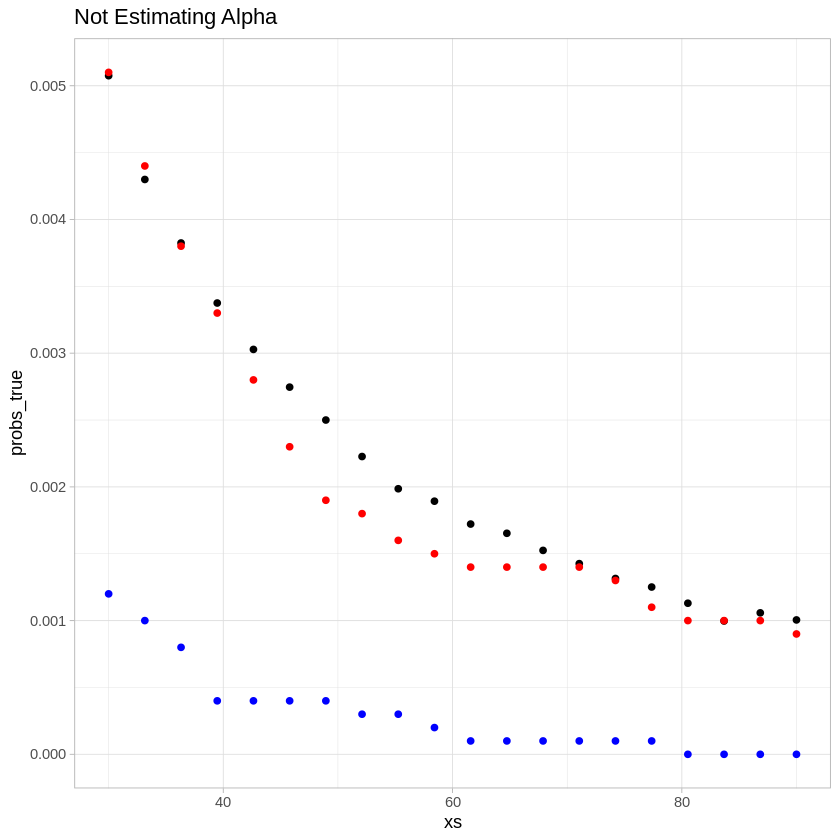

In [73]:
plt_df <- data.frame(xs=xs, probs_HT=probs_HT, probs_emp=probs_emp, probs_true=probs_true)
ggplot(plt_df) + geom_point(aes(x = xs, y=probs_true)) + geom_point(aes(x=xs, y=probs_emp), color='red') + geom_point(aes(x = xs, y=probs_HT), color='blue') + ggtitle('Not Estimating Alpha') + theme_light()

Also checked the performance with respect to choosing $k$ and it seems like it's not great!